In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from DatasetHandler import DatasetHandler
from Model import CNNSpeckleFilter
from utils import *

# Load the dataset

In [3]:
handler = DatasetHandler('dataset_v2')
print("Training dataset size: ", len(handler.train_paths))
print("Validation dataset size: ", len(handler.val_paths))
print("Testing dataset size: ", len(handler.test_paths))

Training dataset size:  2000
Validation dataset size:  600
Testing dataset size:  37


In [4]:
compute_max_min = False

if compute_max_min:
    MAX, MIN = handler.getstats(handler.train_paths)
else:
    MAX = 29968.252
    MIN = 0

print('Dataset max: ', MAX, 'Dataset min: ', MIN)

Dataset max:  29968.252 Dataset min:  0


In [5]:
IMG_SHAPE = (96,96,1)

In [6]:
batch_speckle, batch_clean, batch_noise = next(iter(handler.data_loader(
    paths      = handler.train_paths, 
    batch_size = 1, 
    img_shape  = IMG_SHAPE,
    MAX = MAX,
    MIN = MIN,
    out_noise = True)
))

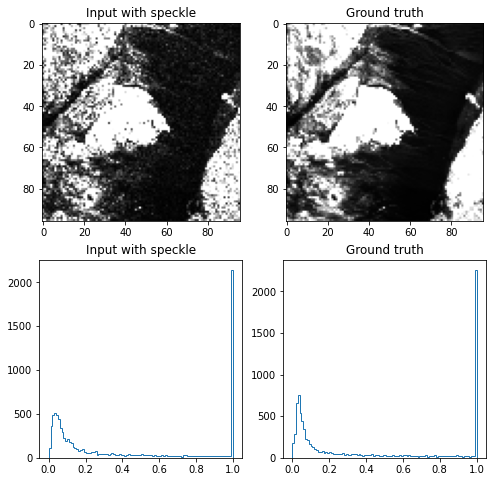

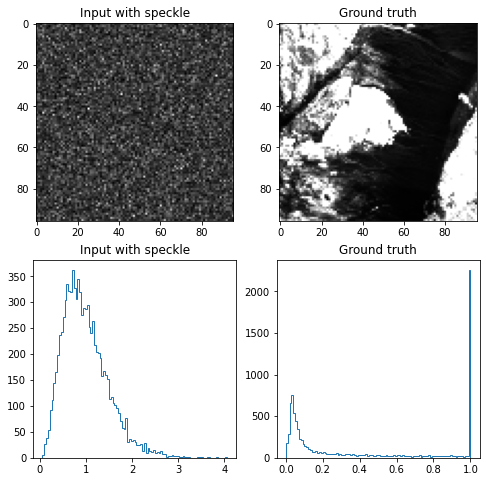

In [7]:
plot_dataset(batch_speckle, batch_clean)
plot_dataset(batch_noise, batch_clean)

# CNN speckle filter training

## Intialize the model


In [ ]:
TRAIN = False

N_LAYER = 12
speckle_filter = CNNSpeckleFilter(input_shape=IMG_SHAPE, n_layers=N_LAYER)
#speckle_filter.model.summary()

if TRAIN:
    epochs = 60
    batch_size = 16

    train_gen = handler.data_loader(
        paths      = handler.train_paths, 
        batch_size = batch_size, 
        img_shape  = IMG_SHAPE,
        MAX = MAX,
        MIN = MIN,
        out_noise = False)

    val_gen = handler.data_loader(
        paths      = handler.val_paths, 
        batch_size = batch_size, 
        img_shape  = IMG_SHAPE,
        MAX = MAX,
        MIN = MIN,
        out_noise = False)

    train_step = len(handler.train_paths)//batch_size
    val_step = len(handler.val_paths)//batch_size

    history = speckle_filter.train_model(epochs, train_gen, val_gen, train_step, val_step)
    speckle_filter.model.save('weights/new_model_'+str(N_LAYER)+'layers_relu.h5')

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
    axes[0].plot(history.history['loss'], label = 'Training')
    axes[0].plot(history.history['val_loss'], label = 'Validation')
    axes[0].legend()

    axes[1].plot(history.history['mae'], label = 'Training')
    axes[1].plot(history.history['val_mae'], label = 'Validation')
    axes[1].legend()
else:
    from tensorflow.keras.models import load_model
    speckle_filter.model = load_model('weights/new_model_'+str(N_LAYER)+'layers.h5')

In [ ]:
IMG_SHAPE = (256,256,1)

In [ ]:
batch_speckle, batch_clean = handler.data_loader_v2(
    paths      = handler.test_paths, 
    img_shape  = IMG_SHAPE,
    MAX = MAX,
    MIN = MIN)

batch_pred = speckle_filter.model.predict(batch_speckle[:,:96,:96,:])

In [ ]:
#plot_model_results(batch_speckle, batch_clean, batch_pred, n=False)

# Compare results

In [ ]:
#!git clone https://github.com/cszn/DPIR.git
#!git clone https://github.com/k-radlak/IDCNN.git
#!git clone https://github.com/grip-unina/SAR-CNN.git

In [ ]:
from test_models import *

In [ ]:
from findpeaks import findpeaks
import findpeaks

def apply_filters(clean, speckle, filter):
    img = findpeaks.stats.scale(speckle[...,0])
    # CLASSICAL
    image_lee, image_lee_enhanced, image_kuan, image_frost, image_mean, image_median, img_fastnl, img_bilateral = test_classic(img)
    # BM3D
    img_bm3d = test_BM3D(img)#speckle[...,0])
    # IDCNN    
    IDCNN = test_IDCNN(img)
    #DNCNN
    res = test_DNCNN(speckle)
    # SARCNN
    pred_int = test_SARCNN(speckle)
    # CNNNLM
    pred_NLM = test_CNNNLM(speckle)
    # Speckle2void
    pred_s2void = test_speckle2void(speckle[np.newaxis,...])
    # SAR2SAR
    pred_sar2sar = test_SAR2SAR(speckle[np.newaxis,...])
    
    imgs = []
    imgs.append(clean[0:64,0:64])
    imgs.append(speckle[0:64,0:64,0])
    imgs.append(filter[0:64,0:64])
    imgs.append(image_lee[0:64,0:64])
    imgs.append(image_lee_enhanced[0:64,0:64])
    imgs.append(image_kuan[0:64,0:64])
    imgs.append(image_frost[0:64,0:64])
    imgs.append(image_mean[0:64,0:64])
    imgs.append(image_median[0:64,0:64])
    imgs.append(img_fastnl[0:64,0:64])
    imgs.append(img_bilateral[0:64,0:64])
    imgs.append(img_bm3d[0:64,0:64])
    imgs.append(res[0,0,0:64,0:64])
    imgs.append(IDCNN[0:64,0:64])
    imgs.append(pred_int[0,0,0:64,0:64])
    imgs.append(pred_NLM[0,0,0:64,0:64])
    imgs.append(pred_s2void[0:64,0:64,0])
    imgs.append(pred_sar2sar[0:64,0:64,0])

    return imgs

In [ ]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

def compute_metrics_2(speckle, clean, filter, name):

    if filter.max()>30:
        filter = filter/255.0

    P_gt_vs_in  = peak_signal_noise_ratio(clean, speckle, data_range=1.0)
    P_gt_vs_pred  = peak_signal_noise_ratio(clean, filter, data_range=1.0)

    print('|PSRN(GT VS SPECKLE): %.2f\tPSNR(GT VS FILTER): %.2f\t |%s' % (P_gt_vs_in, P_gt_vs_pred, name))

    S_gt_vs_in  = structural_similarity(clean, speckle, data_range=1.0)
    S_gt_vs_pred  = structural_similarity(clean, filter, data_range=1.0)

    print('|SSIM(GT VS SPECKLE): %.2f\tSSIM(GT VS FILTER): %.2f\t |%s' % (S_gt_vs_in, S_gt_vs_pred, name))
    
    enl_spe  = (np.mean(speckle)**2)/(np.std(speckle)**2)
    enl_clean = (np.mean(clean)**2)/(np.std(clean)**2)
    enl_filter = (np.mean(filter)**2)/(np.std(filter)**2)

    print('|ENL (SPECKLE      ): %.2f\tENL (CLEAN       ): %.2f\t |%s' % (enl_spe, enl_clean, name))
    print('|ENL (FITLER       ): %.2f\tENL (CLEAN       ): %.2f\t |%s' % (enl_filter, enl_clean, name))
    print('|----------------------------------------------------------------|')
    
    return P_gt_vs_in, P_gt_vs_pred, S_gt_vs_in, S_gt_vs_pred, enl_spe, enl_clean, enl_filter

In [ ]:
P1, P2, S1, S2, E1, E2, E3 = [],[],[],[],[],[],[]

for IMG_N in range(batch_speckle.shape[0]):

  #batch_speckle, batch_clean, batch_pred
  #IMG_N = 3
    
    imgs = apply_filters(batch_clean[IMG_N,...,0], batch_speckle[IMG_N,...], batch_pred[IMG_N,...,0])
    labels = ['Ground Truth','Input With Speckle','Proposed', 'Lee', 'Lee Enhanced', 'Kuan', 'Frost', 'Mean', 'Median', 'Fastnl', 'Bilateral', 'BM3D', 'DnCNN', 'ID-CNN',
              'SAR-CNN', 'CNN-NLM','Speckle2Void', 'SAR2SAR']
    
    print('================================================ TEST %d ================================================' % (IMG_N))
    print('|----------------------------------------------------------------|')
    fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize = (24,18))

    counter = 0
    for i in range(5):
        for j in range(4):
            try:
                axes[i,j].imshow(imgs[counter], cmap = 'gray')

                axes[i,j].set_title(labels[counter], fontsize = 18)
                P_gt_vs_in, P_gt_vs_pred, S_gt_vs_in, S_gt_vs_pred, enl_spe, enl_clean, enl_filter = compute_metrics_2(batch_speckle[IMG_N,:64,:64,0], batch_clean[IMG_N,:64,:64,0], imgs[counter], labels[counter])
                axes[i,j].axis(False)
            except:
                axes[i,j].imshow(np.zeros((64,64)), cmap = 'gray')
                axes[i,j].axis(False)
            counter += 1
            
            P1.append(P_gt_vs_in)
            P2.append(P_gt_vs_pred)
            S1.append(S_gt_vs_in)
            S2.append(S_gt_vs_pred)
            E1.append(enl_spe)
            E2.append(enl_clean)
            E3.append(enl_filter)

    plt.show()

In [ ]:
P1a = np.array(P1)
P2a = np.array(P2)
S1a = np.array(S1)
S2a = np.array(S2)
E1a = np.array(E1)
E2a = np.array(E2)
E3a = np.array(E3)

In [ ]:
scores = np.zeros((P1a.shape[0]//20, 18, 7))
counter = 0
for i in range(P1a.shape[0]//20):
    for j in range(18):
        scores[i,j,0] = P1a[counter]
        scores[i,j,1] = P2a[counter]
        scores[i,j,2] = S1a[counter]
        scores[i,j,3] = S2a[counter]
        scores[i,j,4] = E1a[counter]
        scores[i,j,5] = E2a[counter]
        scores[i,j,6] = E3a[counter]
        counter += 1
    counter += 2

### PSNR

In [ ]:
for i in range(18):
    print(scores[:,i,1].mean())

### SSIM

In [ ]:
for i in range(18):
    print(scores[:,i,3].mean())